In [1]:
%load_ext autotime

## Build Reference PSC

In [2]:
import os
import numpy as np
import pandas as pd
from copy import copy

from glob import glob

from matplotlib import pyplot as plt
plt.style.use('bmh')
from IPython import display

from astropy.time import Time
from astropy.stats import sigma_clip

from piaa.exoplanets import Exoplanet
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils import pipeline

time: 27.1 s


In [3]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809'
sequence = '_'.join(base_dir.split('/')[-3:])
sequence

'PAN012_358d0f_20180822T035809'

time: 8.04 ms


In [4]:
# ticid = 256364928  # HD 189733
# ticid = 11036706
# ticid = 11133818  # Ugly PSF
# ticid = 388448267 # Ugly PSF

# ticid = 417898196
ticid = 

time: 6.25 ms


In [5]:
# Get the list of similar stars. The picid at index 0 is the target star
collection_fn = os.path.join(base_dir, 'vary-{}.csv'.format(ticid))
vary_list = pd.read_csv(collection_fn, names=['picid', 'v'])

time: 183 ms


In [6]:
vary_list.head()

,picid,v
0,417898196,0.000000
1,360882164,0.014627
2,360510889,0.015164
3,393239026,0.015388
4,361197907,0.016129


time: 30.1 ms


### Get stamp collection

Build up a stamp book of the target star and the top references.

In [7]:
stamp_files = glob(os.path.join(base_dir, 'stamps', '*.csv'))

time: 8.87 ms


In [8]:
ref_list = list(vary_list.picid[:200].values)

time: 3.17 ms


In [9]:
camera_bias = 2048

time: 1.57 ms


In [10]:
# Slice frames
# Empirically based
frame_slice = slice(1, -5)

time: 708 µs


In [11]:
stamp_collection = list()

for picid in ref_list:
    stamp_fn = os.path.join(base_dir, 'stamps', f'{picid}.csv')
    ref_table = pd.read_csv(stamp_fn).set_index(['obs_time', 'picid'])
    ref_psc = np.array(ref_table) - camera_bias
    stamp_collection.append(ref_psc)
    
stamp_collection = np.array(stamp_collection)

stamp_collection = stamp_collection[:, frame_slice, :]
image_times = pd.to_datetime(ref_table.index.levels[0].values)[frame_slice]

stamp_collection.shape

(200, 108, 100)

time: 6.25 s


In [12]:
# Get target PSC (may have changed with frame_slice)
target_psc = stamp_collection[0]

num_frames = stamp_collection.shape[1]
num_frames

108

time: 5.52 ms


In [33]:
num_refs = 10

time: 2.22 ms


In [34]:
# Get a normalized version of the entire stamp collection
normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection[:num_refs]])
normalized_collection.shape

(10, 108, 100)

time: 16.8 ms


### Build coeffecients

In [35]:
# Get the coefficients the most optimally combine the normalized referenes into 
# one single master reference.
coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)

time: 8.76 ms


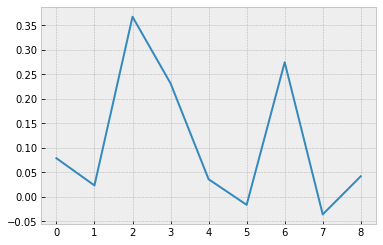

time: 263 ms


In [36]:
plt.plot(coeffs[0])

### Build reference PSC

In [37]:
# Use the coeffecients generated from the normalized references and
# apply them to the non-normalized (i.e. flux) stamps
ideal_psc = pipeline.get_ideal_full_psc(
    stamp_collection[:num_refs], 
    coeffs[0]
).reshape(num_frames, -1)
ideal_psc.shape

(108, 100)

time: 9.24 ms


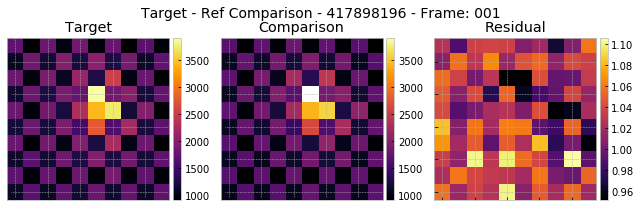

time: 1.17 s


In [49]:
stamp_side = int(np.sqrt(target_psc.shape[1]))

frame_idx = 1

# Reshape into square stamps and plot the requested frame
stamp_fig = plot.show_stamps([
    target_psc.reshape(num_frames, stamp_side, stamp_side), 
    ideal_psc.reshape(num_frames, stamp_side, stamp_side)
], frame_idx=frame_idx, show_residual=True, stretch='linear')

stamp_fig.set_size_inches(9, 3.1)

stamp_fig.suptitle(f'Target - Ref Comparison - {ticid} - Frame: {frame_idx:03d}', 
                   y=1.0, fontsize=14)

stamp_fig.tight_layout()
target_ref_comp_fn = os.path.join(base_dir, f'ref-comparison-{ticid}.png')
stamp_fig.savefig(target_ref_comp_fn, dpi=150)

display.display(stamp_fig)

### Aperture photometry

In [39]:
aperture_size = 5

time: 2.49 ms


In [40]:
lc0 = pipeline.get_aperture_sums(
    target_psc, 
    ideal_psc, 
    image_times, 
    aperture_size=aperture_size, 
    plot_apertures=True,
    aperture_fn=os.path.join(base_dir, 'apertures', f'{ticid}')
)

time: 1min 14s


In [41]:
# Save the lightcurve dataframe to a csv file
# NOTE: We do this before normalizing
csv_file = os.path.join(base_dir, '{}_{}_lc.csv'.format(
    sequence.replace('/', '_'), 
    ticid
))

# Save before adding relative flux
lc0.to_csv(csv_file)

time: 8.14 ms


In [42]:
lc0['rel_flux'] = sigma_clip(lc0.target / lc0.reference).filled(99)
lc0 = lc0.loc[lc0.rel_flux != 99]

time: 12.9 ms


In [43]:
lc0.head()

,color,reference,target,rel_flux
obstime,,,,
2018-08-22 04:07:23,r,9135.765143,9127,0.999041
2018-08-22 04:07:23,g,30893.177116,31826,1.030195
2018-08-22 04:07:23,b,9214.616987,9479,1.028692
2018-08-22 04:09:11,r,9039.030673,9262,1.024667
2018-08-22 04:09:11,g,31009.406489,31392,1.012338


time: 14.1 ms


In [44]:
color_normer = lc0[lc0.rel_flux != 99].groupby('color').rel_flux.apply(lambda x: np.median(x))

time: 8.38 ms


In [45]:
# Get the mean for each channel
# color_normer = lc0[lc0.rel_flux != 99].groupby('color').rel_flux.mean()

time: 470 µs


In [46]:
# Make a copy
lc1 = lc0.copy()

for color, mean in color_normer.iteritems():
    print("{} μ={:.04f}".format(color, mean))
    
    # Get the raw values
    raw_values = lc1.loc[lc1.color == color, ('rel_flux')]
    
    # Get the sigma clipped mean
    mean_values = sigma_clip(raw_values / mean).filled(np.nan)
    
    lc1.loc[lc1.color == color, ('rel_flux')] = mean_values

b μ=0.9835
g μ=1.0123
r μ=1.0259
time: 38.9 ms


In [47]:
ingress = Time('2018-08-22 04:53:00').datetime
midpoint = Time('2018-08-22 05:47:00').datetime
egress = Time('2018-08-22 06:41:00').datetime

time: 3.4 ms


σ=1.2197%


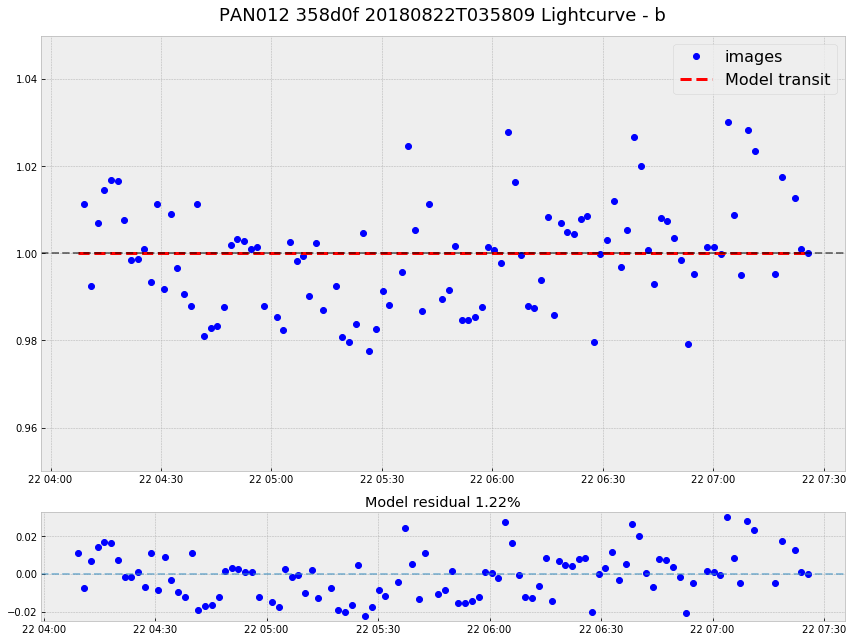

σ=0.7964%


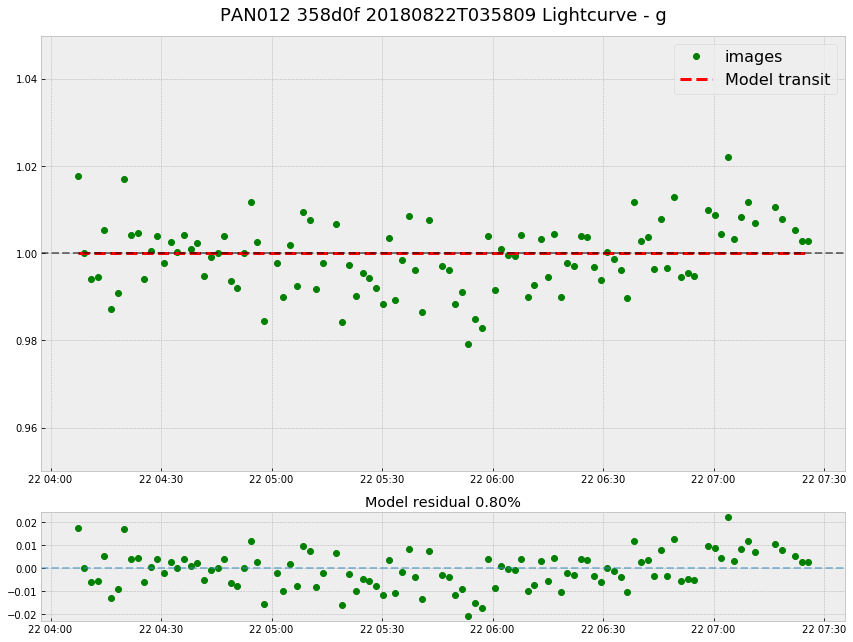

σ=1.6271%


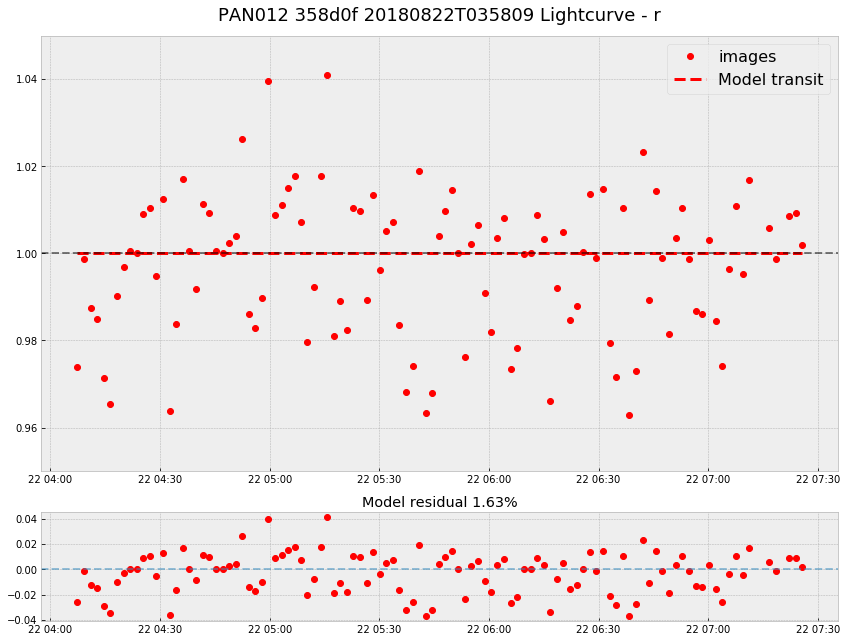

time: 1.98 s


In [48]:
for color, data in lc1.groupby('color'):
        
    y = data.rel_flux
    x = y.index
    
    base_model_flux = np.ones_like(y)
    
    lc_fig = plot.plot_lightcurve(x, y, base_model_flux, 
#         transit_info=[midpoint, ingress, egress],
        title="{} Lightcurve - {}".format(sequence.replace('_', ' '), color),
        ylim=[.9, 1.1], 
        color=color
    )    
    lc_fig.get_axes()[0].set_ylim([0.95, 1.05])
    
    print('σ={:.04%}'.format(y.std()))
       
    display.display(lc_fig)

### Examine

In [29]:
# Detrend by the median value
t0 = target_psc.sum(1) / np.mean(target_psc.sum(1))
i0 = ideal_psc.sum(1) / np.mean(ideal_psc.sum(1))

time: 3.21 ms


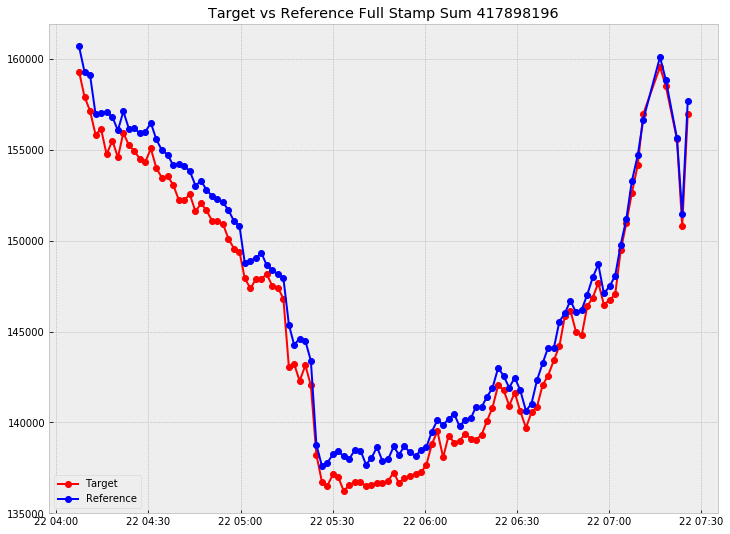

time: 633 ms


In [30]:
plt.figure(figsize=(12, 9))
plt.plot(image_times, target_psc.sum(1), marker='o', c='r', label='Target')
plt.plot(image_times, ideal_psc.sum(1), marker='o', c='b', label='Reference')

# plt.axvline(midpoint, label='mid-transit', ls='-.', c='g')
# plt.axvline(ingress, label='ingress', ls='--')
# plt.axvline(egress, label='egress', ls='--')

plt.title(f'Target vs Reference Full Stamp Sum {ticid}')
plt.legend()

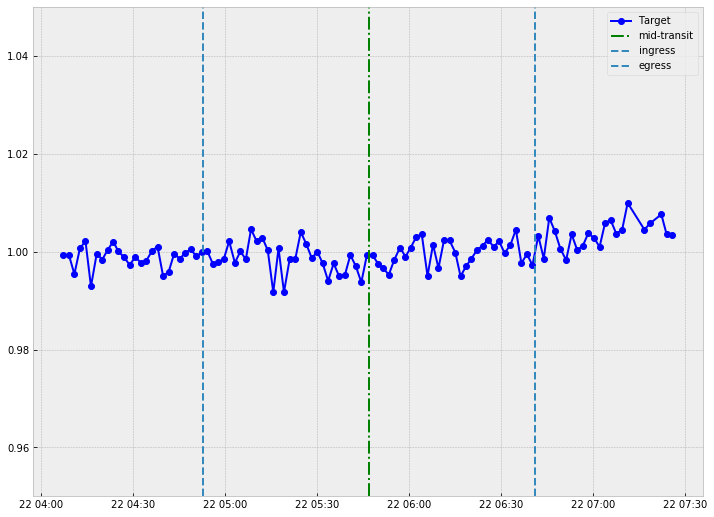

time: 575 ms


In [31]:
plt.figure(figsize=(12, 9))
plt.plot(image_times, t0 / i0, marker='o', c='b', label='Target')

plt.axvline(midpoint, label='mid-transit', ls='-.', c='g')
plt.axvline(ingress, label='ingress', ls='--')
plt.axvline(egress, label='egress', ls='--')

plt.ylim([.95, 1.05])

plt.legend()